📊 Statystyki intensywności:
Min: 0.0 Max: 1.0 Mean: 0.11816271559157304 Std: 0.16712824151979647
🔍 Obliczanie lokalnych statystyk Z-score...
🧼 Czyszczenie maski...
📦 Objętość nasion (mm³): 2175.59
🧮 Liczba wykrytych ziaren w projekcie: 433
📐 Współczynnik Jaccarda: 0.3003
📏 Liczba ziaren w masce referencyjnej: 595


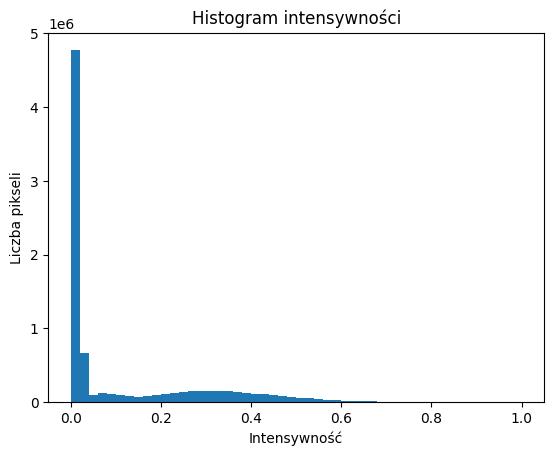

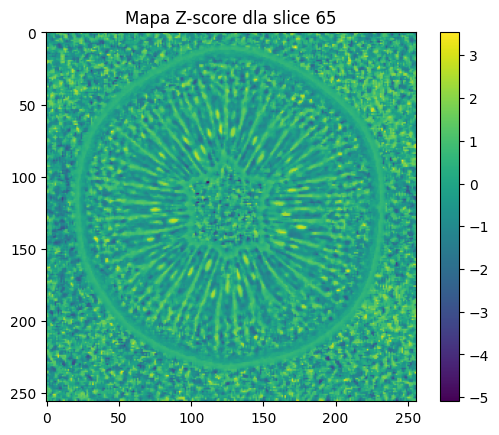

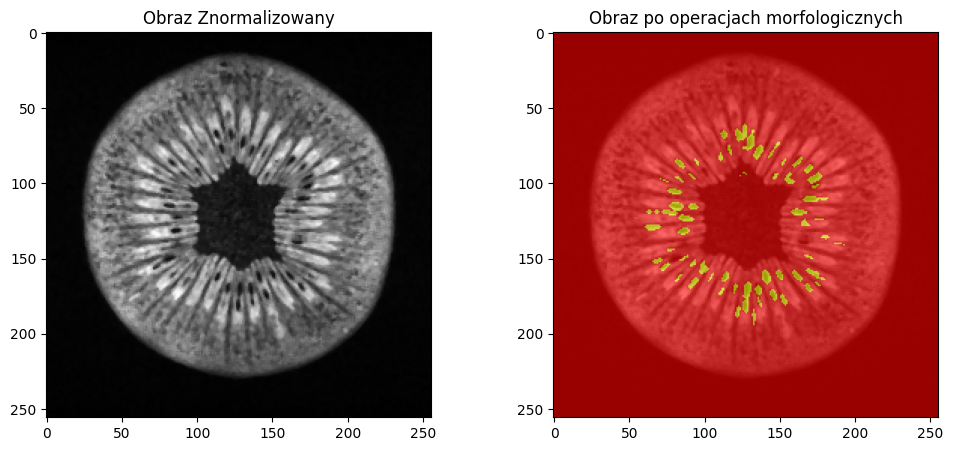

In [9]:
import nibabel as nib
import numpy as np
import scipy.ndimage as ndi
from skimage.measure import label as sk_label, regionprops
from skimage.morphology import ball, binary_closing, binary_dilation, binary_opening
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
import os

def create_ring_mask(shape, center=None, inner_radius=25, outer_radius=80):
    h, w = shape
    if center is None:
        center = (int(h/2), int(w/2))
    Y, X = np.ogrid[:h, :w]
    dist_sq = (X - center[1])**2 + (Y - center[0])**2
    mask = (dist_sq >= inner_radius**2) & (dist_sq <= outer_radius**2)
    return mask

# === Ścieżki ===
input_path = r"C:\Users\HP\Desktop\Studia Inżynieria\R2 s2\Przetwarzanie obrazów i grafika komputerowa\Labolatoria\Projekt\Dane\kiwi_bergen.nii.gz"
output_mask_path = "mask_seeds_balanced.nii.gz"
reference_mask_path = r"C:\Users\HP\Desktop\Studia Inżynieria\R2 s2\Przetwarzanie obrazów i grafika komputerowa\Labolatoria\Projekt\Dane\kiwi_bergen_wzorzec.nii"

# === Parametry segmentacji ===
z_start = 20
z_end = 110
window_size = 7
zscore_threshold = 0.90
area_min = 16
area_max = 40
eccentricity_max = 0.98
solidity_min = 0.70
remove_small_objects_voxels = 10
dilate_radius = 1
inner_radius_center = 30
inner_radius_min = 20
outer_radius_center = 70
outer_radius_min = 50

# === Wczytanie danych ===
img = nib.load(input_path)
data = img.get_fdata()
affine = img.affine

# === Medianowe filtrowanie i normalizacja ===
filtered = ndi.median_filter(data, size=3)
normed = (filtered - np.min(filtered)) / (np.max(filtered) - np.min(filtered))

# === Diagnostyka obrazu ===
print("📊 Statystyki intensywności:")
print("Min:", normed.min(), "Max:", normed.max(), "Mean:", normed.mean(), "Std:", normed.std())

plt.figure()
plt.hist(normed.ravel(), bins=50)
plt.title("Histogram intensywności")
plt.xlabel("Intensywność")
plt.ylabel("Liczba pikseli")

print("🔍 Obliczanie lokalnych statystyk Z-score...")
local_mean = ndi.uniform_filter(normed, size=window_size)
local_sqr_mean = ndi.uniform_filter(normed**2, size=window_size)
local_std = np.sqrt(local_sqr_mean - local_mean**2) + 1e-6
zscore_map = (local_mean - normed) / local_std
zscore_candidates = zscore_map > zscore_threshold

# Podgląd Z-score
slice_id_diag = (z_start + z_end) // 2
plt.figure()
plt.imshow(zscore_map[:, :, slice_id_diag], cmap='viridis')
plt.title("Mapa Z-score dla slice " + str(slice_id_diag))
plt.colorbar()

# === Segmentacja slice-by-slice ===
final_mask = np.zeros_like(data, dtype=np.uint8)
z_center = (z_start + z_end) / 2
max_d = max(z_center - z_start, z_end - z_center)

for z in range(z_start, z_end + 1):
    shape = data[:, :, z].shape
    cy, cx = shape[0] // 2, shape[1] // 2

    d = abs(z - z_center)
    scale = 1 - (d / max_d)
    r_in = inner_radius_min + (inner_radius_center - inner_radius_min) * scale
    r_out = outer_radius_min + (outer_radius_center - outer_radius_min) * scale

    ring_mask = create_ring_mask(shape, inner_radius=r_in, outer_radius=r_out)
    candidates_slice = zscore_candidates[:, :, z] & ring_mask

    labeled_slice = sk_label(candidates_slice)
    for prop in regionprops(labeled_slice):
        y, x = prop.centroid
        dist = np.sqrt((x - cx)**2 + (y - cy)**2)
        if (area_min < prop.area < area_max and
            prop.eccentricity < eccentricity_max and
            prop.solidity > solidity_min and
            r_in <= dist <= r_out):
            final_mask[:, :, z][labeled_slice == prop.label] = 1

# === Morfologia ===
print("🧼 Czyszczenie maski...")
final_mask = binary_closing(final_mask, ball(1))
labeled_final = sk_label(final_mask)
cleaned_mask = np.zeros_like(final_mask, dtype=np.uint8)

for region in regionprops(labeled_final):
    if region.area >= remove_small_objects_voxels:
        cleaned_mask[labeled_final == region.label] = 1

final_mask = binary_dilation(cleaned_mask, ball(dilate_radius)).astype(np.uint8)
final_mask = ndi.median_filter(final_mask, size=2)
final_mask = binary_opening(final_mask, ball(1)).astype(np.uint8)

# === Zapis maski
nib.save(nib.Nifti1Image(final_mask, affine), output_mask_path)

# === Statystyki własne
voxel_volume = 0.2344 * 0.2344 * 0.5  # mm³
seeds_volume = np.sum(final_mask) * voxel_volume
print("📦 Objętość nasion (mm³):", round(seeds_volume, 2))

# === Liczenie ziaren projektu
labeled_proj = sk_label(final_mask)
count_proj = len(np.unique(labeled_proj)) - 1
print(f"🧮 Liczba wykrytych ziaren w projekcie: {count_proj}")

# === Ocena względem maski referencyjnej
if not os.path.exists(reference_mask_path):
    print("⚠️ Brak maski wzorcowej:", reference_mask_path)
else:
    ref_img = nib.load(reference_mask_path)
    ref_data = ref_img.get_fdata().astype(np.uint8)

    if final_mask.shape != ref_data.shape:
        raise ValueError("❌ Maska wzorcowa ma inne wymiary niż wynik segmentacji!")

    # Jaccard
    jaccard = jaccard_score(ref_data.ravel(), final_mask.ravel())
    print(f"📐 Współczynnik Jaccarda: {jaccard:.4f}")

    # Liczenie ziaren w masce wzorcowej
    labeled_ref = sk_label(ref_data)
    count_ref = len(np.unique(labeled_ref)) - 1
    print(f"📏 Liczba ziaren w masce referencyjnej: {count_ref}")

# === Podgląd przykładowego slice'a
slice_id = 60
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(normed[:, :, slice_id], cmap='gray')
plt.title("Obraz Znormalizowany")

plt.subplot(1, 2, 2)
plt.imshow(normed[:, :, slice_id], cmap='gray')
plt.imshow(final_mask[:, :, slice_id], cmap='autumn', alpha=0.6)
plt.title("Obraz po operacjach morfologicznych")
plt.show()

In [ ]:
from skimage.filters import threshold_otsu

print("🥝 Segmentacja całego kiwi slice-by-slice (Otsu)...")
mask_fruit = np.zeros_like(normed, dtype=bool)

for z in range(10, 117):
    slice_ = normed[:, :, z]
    try:
        thresh = threshold_otsu(slice_)
        binary = slice_ > thresh * 0.9
    except:
        binary = slice_ > 0.6

    binary = ndi.binary_closing(binary, structure=np.ones((3, 3)))
    binary = ndi.binary_fill_holes(binary)

    mask_fruit[:, :, z] = binary

# Oczyszczenie – zachowujemy tylko największy obiekt 3D
labeled_fruit = sk_label(mask_fruit)
regions = regionprops(labeled_fruit)
if regions:
    largest = max(regions, key=lambda r: r.area)
    mask_fruit = (labeled_fruit == largest.label)

# Zapis i objętość
nib.save(nib.Nifti1Image(mask_fruit.astype(np.uint8), affine), "mask_fruit.nii.gz")
fruit_volume = np.sum(mask_fruit) * voxel_volume

# Tabela wyników
print("\n=== 📊 PODSUMOWANIE ===")
print(f"Liczba ziaren: {count_proj}")
print(f"Objętość nasion: {seeds_volume:.2f} mm³")
print(f"Objętość całego kiwi: {fruit_volume:.2f} mm³")

volume_ratio = seeds_volume / fruit_volume if fruit_volume > 0 else 0
print(f"Stosunek objętości nasion do owocu: {volume_ratio:.4f}")

🥝 Segmentacja całego kiwi slice-by-slice (Otsu)...

=== 📊 PODSUMOWANIE ===
Liczba ziaren: 433
Objętość nasion: 2175.59 mm³
Objętość całego kiwi: 77576.89 mm³
Stosunek objętości nasion do owocu: 0.0280
